In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils

from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles

from keras import backend as K
import matplotlib.pyplot as plt
import re
import hexdump

print("TensorFlow version: {}".format(tf.__version__))

2021-12-30 18:52:59.457933: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory
2021-12-30 18:52:59.458021: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory
2021-12-30 18:52:59.458030: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Using TensorFlow backend.


TensorFlow version: 2.1.1


(500, 2)
(500,)


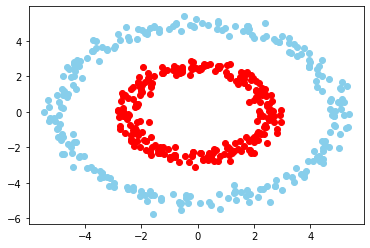

In [5]:
X , Y  = make_circles(n_samples=500, factor=0.5, noise=0.05)
X = 5*X

plt.scatter(X[Y==0,0],X[Y==0,1],c="skyblue")
plt.scatter(X[Y==1,0],X[Y==1,1],c="red")

print(np.shape(X))
print(np.shape(Y))

In [6]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,train_size=0.8,random_state=23)


X_train_1 = K.cast_to_floatx (X_train)
X_test_1 = K.cast_to_floatx (X_test)
y_train_1 = K.cast_to_floatx (y_train)

In [7]:
# El modelo
model= tf.keras.Sequential()

model.add(layers.Dense(16, activation='relu', input_dim=2))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Configulación del entrenamiento
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


2021-12-30 18:53:08.182685: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-30 18:53:08.182718: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-30 18:53:08.182742: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2021-12-30 18:53:08.182963: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-12-30 18:53:08.202132: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2699905000 Hz
2021-12-30 18:53:08.202484: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55febe1ed610 initialized for platform Host (this does not guarantee that XLA 

Iniciar el entrenamiento
Train on 400 samples
Epoch 1/100
400/400 [==============================] - 1s 2ms/sample - loss: 0.2167 - accuracy: 0.5225
Epoch 2/100
400/400 [==============================] - 0s 1ms/sample - loss: 0.1822 - accuracy: 0.7150
Epoch 3/100
400/400 [==============================] - 0s 1ms/sample - loss: 0.1457 - accuracy: 0.9475
Epoch 4/100
400/400 [==============================] - 0s 1ms/sample - loss: 0.1033 - accuracy: 0.9925
Epoch 5/100
400/400 [==============================] - 0s 1ms/sample - loss: 0.0640 - accuracy: 1.0000
Epoch 6/100
400/400 [==============================] - 0s 1ms/sample - loss: 0.0354 - accuracy: 1.0000
Epoch 7/100
400/400 [==============================] - 0s 1ms/sample - loss: 0.0195 - accuracy: 1.0000
Epoch 8/100
400/400 [==============================] - 0s 1ms/sample - loss: 0.0113 - accuracy: 1.0000
Epoch 9/100
400/400 [==============================] - 0s 1ms/sample - loss: 0.0069 - accuracy: 1.0000
Epoch 10/100
400/400 [=====

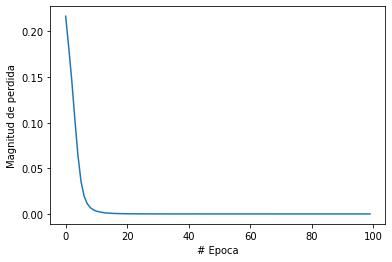

In [8]:
print("Iniciar el entrenamiento")
historial = model.fit(X_train_1,y_train_1, epochs=100,batch_size=1,verbose=True)
print("Modelo Entrenado")

plt.xlabel("# Epoca")
plt.ylabel("Magnitud de perdida")
plt.plot(historial.history["loss"])

In [9]:
loss, accuracy = model.evaluate(X_test_1, y_test, verbose=0)
print("Test accuracy : " + str(accuracy))


Test accuracy : 1.0


In [15]:
model.save("saved_model/model")
print("Saved model to disk")

# load model
savedModel = load_model("saved_model/model")
savedModel.summary()


INFO:tensorflow:Assets written to: saved_model/model/assets
Saved model to disk
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [16]:
def port(model, optimize=False, variable_name='model_data', pretty_print=False):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    if optimize:
        if isinstance(optimize, bool):
            optimizers = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
        else:
            optimizers = optimize
        converter.optimizations = optimizers
    tflite_model = converter.convert()
    bytes = hexdump.dump(tflite_model).split(' ')
    c_array = ', '.join(['0x%02x' % int(byte, 16) for byte in bytes])

    return c_array.split(",")



In [ ]:
text = port(model,variable_name="mi_data")
text